# Meetup Mexico analysis


Tech meetups are events where people get together to network and share skills. Meetup is a platform used by many people to set up these events. We have previously used the platform to analye levels of activity in different creative communities in the UK.

For creative industries mapping project, we have collected data about all tech meetups in Mexico. Our goal is to measure levels of creative networking in different cities, how this has evolved and the networks between them. In order to do this we need to do some data processing:

* We need to identify creative communities -> We perform a topic modelling analysis in the keywords used by conference organisers to tag their events. This gives us a set of topics we can then classify into creative / non-creative categories.

* We need to geocode creative communities -> We place each group in a Mexican state using their longitde and latitude and a shapefile defining the states as polygons.

* We need to map relations between communities -> We use overlaps between individual memberships in communities to proxy their interactions: those communities with more intersections in their populations are more strongly connected than those with less.

## Preamble

* Imports, directory management and functions


In [1]:
%matplotlib inline

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Other imports 

#Zipfile to work with zips.
import zipfile

#Spacy and geopandas for spatial stuff
import spacy
import geopandas as gp

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data
ext_data = os.path.join(top,'data/external')

#Metadata
meta_data = os.path.join(top,'data/metadata')

#Interim data
int_data = os.path.join(top,'data/interim')

#Processed data
proc_data = os.path.join(top,'data/processed')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Tables
tab_path = os.path.join(top,'reports/tables')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [2]:
#Function to save figures

def save_fig(name,today_str=today_str):
    '''
    Saves a plot
    
    '''
    plt.savefig(fig_path+'/{today}_{name}.pdf'.format(today=today_str,name=name),bbox_inches='tight')


In [3]:
sys.version
from setuptools import find_namespace_packages

## 1. Load data

### Load metadata

Load shapefiles for mapping. We downloaded them from [here](http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_geoestadistico.aspx).

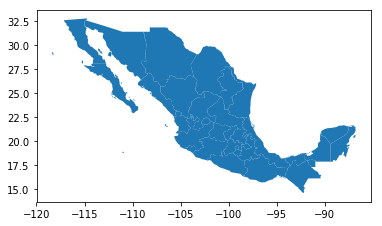

In [16]:
#estados = gp.read_file(meta_data+'/inegi_shapefile/conjunto_de_datos/areas_geoestadisticas_estatales.shp')
#We use a shapefile using the WSG standard. 
#The shapefile from inegi which we used in our DENUE analysis is based in a different projection.
estados = gp.read_file(meta_data+'/mexstates/mexstates.shp')

#Viva México!
estados.plot()

### Load meetup group data

In this json file, each element is a group with some metadata


In [17]:
from data_getters.meetup import select_meetup
import pymysql


config_path = '/Users/jmateosgarcia/Desktop/projects_2017/mexico/mexico_mapping/notebooks/innovation-mapping.config'

dfs = select_meetup(config_path, 34, "MX")

for k, df in dfs.items():
    print(k, len(df))

core_groups 725
core_members_groups 133080
extended_groups 3291
extended_members_groups 15203


In [23]:
#Focus on Mexican groups
mex_groups = dfs['core_groups']

print(len(mex_groups))

print(mex_groups['members'].sum())

725
227278


There are 725 tech groups in the data with 227278 members

In [53]:
#Some of the lists have been turned into strings. We will evaluate them as literals

from ast import literal_eval

mex_groups['topics'] = [literal_eval(x) for x in mex_groups['topics']]



### Load meetup member data

In [37]:
#Extract users with mexican ids
mex_users = dfs['core_members_groups']

len(set(mex_users['member_id']))

49392

49.392 unique individuals

In [39]:
#Create group membership lists
#First we create a container for members
group_memberships = {x:[] for x in set([x['group_id'] for r,x in mex_users.iterrows()])} 

In [40]:
#Then we go through each member and append them to each group
for i,user in mex_users.iterrows():
    group_memberships[user['group_id']].append(user['member_id'])

## 2. Processing data

There are two bits of processing we need to do before we get started with the analysis:

1. Classify groups into categories (to identify the creative groups)
2. Classify groups into states (for mapping etc.) 


### Classify groups into topics (including creative topics)

As a first pass we will use LDA, a topic modelling algorithm that extracts topics from collections of words. To do this efficiently, we will create a small pipeline using the gensim package for Natural language processing


In [55]:
#What are the top topics?

#First we need to extract the topics from the json object.
#Every element has an element with a list of topics for which we want to extract the tidy,
#easy to analyse  unique url keys
#mex_topics_dict = {str(int(x['id'])):[top['urlkey'] for top in x['topics']] for x in mex_groups}

#And this is a list where every element is the list of keywords
#mex_topics_list = list(mex_topics_dict.values())

mex_topics_list = [[top['urlkey'] for top in x['topics']] for x in mex_groups.to_dict(orient='records')]

In [56]:
#Count the top keywords
meetup_kw_distr = pd.Series([x for el in mex_topics_list for x in el]).value_counts()

#What are the top 10?
meetup_kw_distr[:10]

softwaredev             308
computer-programming    298
newtech                 272
web-development         224
opensource              201
web                     188
mobile-development      112
webdesign               100
javascript               92
mobile-technology        91
dtype: int64

In [57]:
#What's the distribution?

meetup_kw_distr.describe()

count    1436.000000
mean        5.574513
std        18.781432
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       308.000000
dtype: float64

Very skewed  - there are 2053 topics, but most appear very few times.
Let's see if LDA works and if not we will train the algorithm on a bigger corpus also including UK and 
UAE groups

In [58]:
#Create the LDA pipeline

from gensim import corpora, models

In [59]:
class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised_filtered = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
        
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [67]:
#Extract test topics

test = LdaPipeline(mex_topics_list).filter(3).process().tfidf().fit_lda(
    num_topics=100,passes=50,iterations=150).predict_topics()

/usr/local/lib/python3.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [68]:
#We extract the topic mixes to label and classify as creative or non-creative.
#We'll do that by hand in excel
topic_mixes = pd.DataFrame(test.lda_topics[:100])

topic_mixes.columns=['topic_number','topic_mix']

topic_mixes.to_csv(top+'/references/{date}_topic_mix_for_labelling_70.csv'.format(date=today_str),index=False)

In [20]:
#Load the labelled groups
topic_mixes_labelled = pd.read_csv(top+'/references/7_2_2018_topic_mix_for_labelling_70_labelled.csv')

#Now we name the groups
groups_test = test.predicted_df

groups_test.columns = topic_mixes_labelled['segment']

#We had some repaat groups so we should melt, aggregate their weights over groups and pivot
groups_test_2 = pd.pivot_table(pd.melt(groups_test.reset_index(drop=False),
                       id_vars='index').groupby(['index','segment'])['value'].sum().reset_index(drop=False),
                               index='index',columns='segment',values='value')

#We use idxmax to get the top topic for each group
groups_test_2['top_topic'] = groups_test_2.idxmax(axis=1)


### Now to process each lat lon into its state polygon

In [21]:
from geopandas.geoseries import *

def point_in_poly(point,poly):
    '''
    This function checks if a point is inside a polygon and returns the result
    
    
    '''
    
    result = poly.contains(point)
    
    return(result)
    

In [22]:
#This turns each meetup lat/lon into a geographical point we can search for in a polygon
meetup_geo_points = [(x['id'],Point(x['lon'],x['lat'])) for x in mex_groups]

In [23]:
#This container stores the states
cont = []

for point in [x[1] for x in meetup_geo_points]:
    
    #Applies the function above
    result = [point_in_poly(point,estados.loc[num,'geometry']) for num in np.arange(len(estados))]
    
    #Finds the state name that contains the point
    try:
        name = [x for x,y in zip(estados['ADMIN_NAME'],result) if y==True][0]
    
    #We had a problem with one of them
    except:
        name = np.nan
    
    #Returns all contents
    cont.append(name)

### Final data combination

We want a dataframe with:

* Group name
* State
* Lat and lon
* top topic
* date it started
* List of members


In [24]:
#This lookup represents creative activities
meetup_topic_sector_lookup = {x:y if type(y)==str else 'not_creative' for x,y in zip(topic_mixes_labelled.segment,topic_mixes_labelled.creative_sector)}


In [25]:
#Key variables for the dataframe
mu_df = pd.concat([pd.DataFrame({'name':x['name'],
                                        'city':x['city'],
                                        'created':x['created'],
                                        'lat':x['lat'],
                                        'lon':x['lon']},
                                       index=[x['id']]) for x in mex_groups]).reset_index(drop=False)

#Add a list with topics
mu_df['keyword_list'] = [[top['urlkey'] for top in x['topics']] for x in mex_groups]

#Add the top topic (they were in the same order)
mu_df['top_topic'] = groups_test_2['top_topic']

#Add the sector
mu_df['sector'] = [meetup_topic_sector_lookup[x] for x in mu_df['top_topic']]


#Add the state
mu_df['state'] = cont

#Add the list of members
mu_df['member_list'] = [group_memberships[x] if x in group_memberships.keys() else [] 
                                for x in mu_df['index']]

mu_df['member_n'] = [len(x) for x in mu_df['member_list']]

#And now get the year the meetup was created from the timestamp. NB we divide by 1000 to go from miliseconds
#to seconds
mu_df['year'] = [datetime.datetime.fromtimestamp(x/1000).year for x in mu_df['created']]

#What does it look like?
mu_df.head()

,index,city,created,lat,lon,name,keyword_list,top_topic,sector,state,member_list,member_n,year
0,20452845.0,México City,1.474504e+12,19.43,-99.14,100Seos,"[wordpress, online-marketing, seo-search-engin...",seo,advertising,Distrito Federal,"[14454697, 14482510, 20452845, 63309822, 10055...",45,2016
1,20412115.0,Venustiano Carranza,1.473559e+12,16.35,-92.55,2° CONGRESO INTERNACIONAL DE EMPRENDIMIENTO,"[sales, innovation, women-entrepreneurs, busin...",entrepreneurship,not_creative,Chiapas,"[20412115, 184953845, 197577471, 198562505, 19...",68,2016
2,26236635.0,León,1.507775e+12,21.12,-101.69,6 Pasos para Duplicar tus Ventas con una Tiend...,"[building-an-online-business, startup-business...",apps,software,Guanajuato,"[26236635, 161787022, 182915855, 193337196, 22...",21,2017
3,23443010.0,Mérida,1.493227e+12,20.97,-89.62,Academia de Exito Financiero CashFlow,"[investing, financial-planning, professional-n...",data_analytics,software,Yucatan,"[1617357, 198844093, 230329980]",3,2017
4,23787260.0,Guadalajara,1.494865e+12,20.67,-103.35,Access Silicon Valley (Guadalajara),"[mobile-technology, raising-capital, entrepren...",startups,software,Jalisco,"[3869358, 4100044, 10028425, 11525343, 1278370...",234,2017


This dataframe has everything we need for some fun analysis

## 3. Exploratory data analysis

Charts to produce:

* Barchart with activity (total groups and members) by segment with colours by sector
* Timeline of activity by creative industries sector (groups)
* State activity by segment
* Map with bubbles showing activity by sector
* Mexican network
* Topic network


### Chart 1: Distribution of activity by topic

In [26]:
from matplotlib import patches

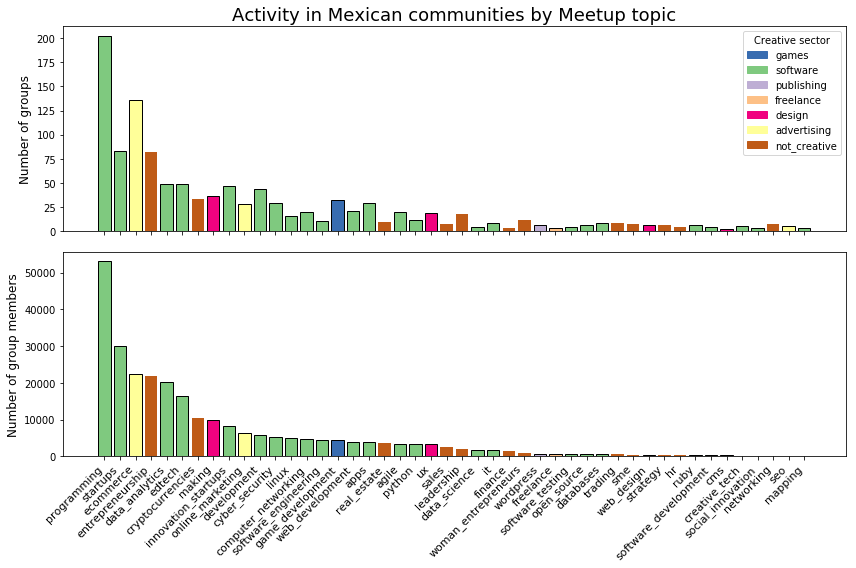

In [27]:
# Barchart

#Create activity stats
mu_distr = pd.concat([mu_df['top_topic'].value_counts(),mu_df.groupby('top_topic')[
    'member_n'].sum()],axis=1).sort_values('member_n',ascending=False)


#Plot

#Get colors

sector_color_lookup = {x:y for x,y in zip(set(mu_df.sector),
                                              plt.cm.get_cmap('Accent').colors[:len(set(mu_df.sector))])}


#Plot
fig, ax = plt.subplots(figsize=(12,8),nrows=2,sharex=True)


for number,x in enumerate(mu_distr.index):
    ax[0].bar(number,mu_distr.loc[x]['top_topic'],width=0.8,
              color=sector_color_lookup[meetup_topic_sector_lookup[x]],
              edgecolor='black' if meetup_topic_sector_lookup[x]!='not_creative' else None)
    ax[1].bar(number,mu_distr.loc[x]['member_n'],width=0.8,
             color=sector_color_lookup[meetup_topic_sector_lookup[x]],
              edgecolor='black' if meetup_topic_sector_lookup[x]!='not_creative' else None)

#Create custom legend
custom_patches = [
    patches.Patch(color=c,label=l) for l,c in sector_color_lookup.items()]
    
ax[0].legend(handles=custom_patches,title='Creative sector')

#Some other tidying up
ax[0].set_ylabel('Number of groups',size=12)
ax[1].set_ylabel('Number of group members',size=12)

#Add xlabels
#Numbers for the ticks
ax[0].set_xticks(np.arange(len(mu_distr.index)))

#And values
ax[1].set_xticklabels(mu_distr.index,rotation=45,ha='right',size=11)

#And title
ax[0].set_title('Activity in Mexican communities by Meetup topic',size=18)

plt.tight_layout()

#Save
save_fig('meetup_activity')




### Chart 2: Timeline of activity by sector (and as a share of total)

In [28]:
#Create the variables to plot, dropping the last year
activity_totals = pd.crosstab(mu_df.sector,mu_df.year).drop(2018,axis=1)
activity_totals_norm = pd.crosstab(mu_df.sector,mu_df.year,normalize=1).drop(2018,axis=1)

#Get the sorted sectors so that we have the biggest ones at the bottom of the barchart
sectors_sorted = activity_totals.loc[:,2017].sort_values(ascending=False).index


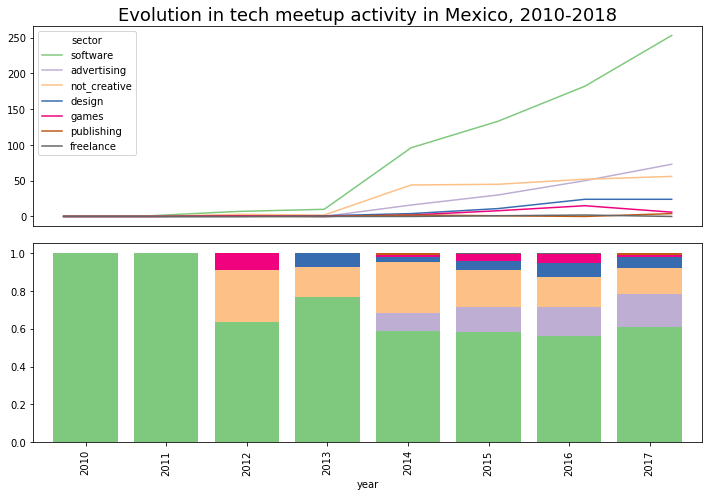

In [29]:
#Plot
fig,ax = plt.subplots(figsize=(10,7),nrows=2)

activity_totals.T.loc[:,sectors_sorted].plot(ax=ax[0],cmap='Accent')
activity_totals_norm.T.loc[:,sectors_sorted].plot.bar(ax=ax[1],stacked=True,cmap='Accent',width=0.8)


ax[0].get_xaxis().set_visible(False)
ax[1].legend().set_visible(False)

ax[0].set_title('Evolution in tech meetup activity in Mexico, 2010-2018',size=18)

plt.tight_layout()

save_fig('meetup_timeline')


### Chart 3: State activity by segment

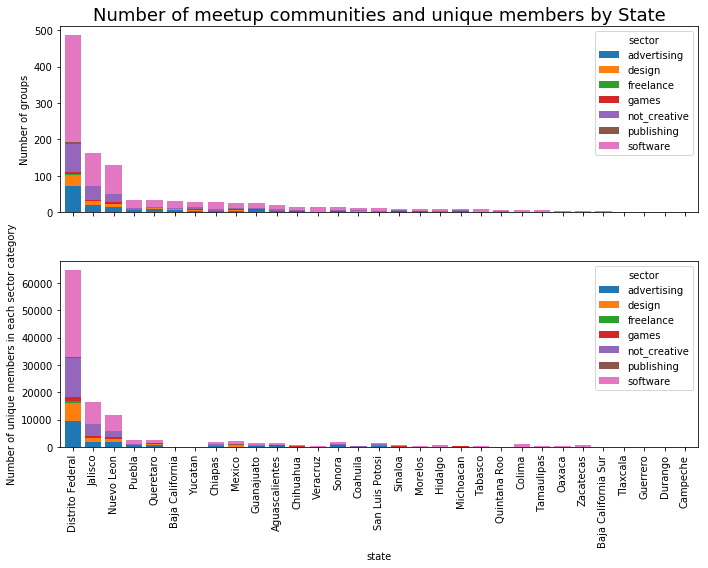

In [98]:
#State activity by segment...

fig,ax = plt.subplots(figsize=(10,8),nrows=2,sharex=True)

#We need a variable to sort by: total number of groups in a location

states_meetup_sorted = pd.crosstab(mu_df.state,mu_df.sector).sum(axis=1).sort_values(ascending=False).index


#Total number of groups
pd.crosstab(mu_df.state,mu_df.sector).loc[states_meetup_sorted,:].plot.bar(stacked=True,ax=ax[0],width=0.8)

#Unique members in each sector
pd.pivot_table(mu_df.groupby(['state','sector'])['member_list'].apply(
    lambda x: len(set([val for el in x for val in el]))).reset_index(drop=False),
               index='state',columns='sector',values='member_list').fillna(0).loc[
    states_meetup_sorted,:].plot.bar(stacked=True,ax=ax[1],width=0.8)

ax[0].set_ylabel('Number of groups')
ax[1].set_ylabel('Number of unique members in each sector category')

ax[0].set_title('Number of meetup communities and unique members by State',size=18)

plt.tight_layout()

save_fig('state_meetup_activity')


In [294]:
creat_state = pd.crosstab(mu_df.state,mu_df.sector).drop('not_creative',axis=1).sum(axis=1)
creat_state.sort_values(ascending=False)/creat_state.sum()



state
Distrito Federal       0.428721
Jalisco                0.131027
Nuevo Leon             0.115304
Queretaro              0.032495
Puebla                 0.029350
Baja California        0.028302
Mexico                 0.024109
Yucatan                0.023061
Chiapas                0.023061
Guanajuato             0.023061
Aguascalientes         0.015723
Veracruz               0.013627
Chihuahua              0.013627
Sonora                 0.012579
Coahuila               0.010482
Morelos                0.008386
Hidalgo                0.008386
San Luis Potosi        0.007338
Sinaloa                0.007338
Michoacan              0.006289
Tabasco                0.006289
Colima                 0.005241
Quintana Roo           0.005241
Tamaulipas             0.005241
Zacatecas              0.005241
Oaxaca                 0.003145
Baja California Sur    0.003145
Tlaxcala               0.002096
Guerrero               0.001048
Campeche               0.001048
Durango                0.000000
dt

### Chart 4: Connectivity between communities

In [106]:
#Functions
def extract_network_from_corpus(label_corpus, edge_attr="None", stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
        #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus.iloc[i], 2))

        #Extract these as lists of dicts capturing connections between topics, and add those to the container.
        #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]

            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)

In [221]:
#We will plot networks between communities

class meetupNetworks():
    '''
    This class creates meetup networks
    We feed it a df with a members list that it uses to create the network
    and metadata for subsetting and visualisation.
    
    '''
    
    def __init__(self,meetup_df):
        '''
        Initialise with the meetup df
        '''
        
        self.df = meetup_df
        
    def get_all_network(self,thres=None):
        '''
        Takes the membership list and makes a network
        
        '''
        #Load the df
        mu_df = self.df
        
        #Flip the data around to create a list where every element is shared group overlaps for individuals
        
        g_m_df = pd.concat([pd.DataFrame({'m':mu_df.loc[x,'member_list'],
                                          'g':mu_df.loc[x,'name']}) for x in np.arange(0,len(mu_df))]).groupby(
            'm')['g'].apply(lambda x: list(x)).reset_index(drop=True)
        
        #Extract network with my function
        network = extract_network_from_corpus(g_m_df)
        
        #Now we want to add metadata to the network
        #Sometimes it is way easier to work with dicts. We create one
        mu_df_dict = mu_df.to_dict(orient='records')
        mu_df_dict_2 = {x['name']:x for x in mu_df_dict}
        
        #Now we loop over the nodes in the network and give them metadata
        network = enrich_nodes(network,mu_df_dict_2)
        
        
        self.network=network
        self.node_metadata = mu_df_dict_2
            
        return(self)
        
    def subset_network(self,sector):
        '''
        Subsets the network to focus on a sector
    
        '''
        network = self.network
            
        network = nx.subgraph(network_test,nbunch=[n for n in network_test.node if network_test.node[n][
            'sector'] in sector])
        
        self.network = network

        
        return(self)
    
    def filter_weights(self,thres):
        '''
        Filters weights below a certain threshold (quantile in the degree distribution)
        
        '''
        network = self.network 
            
        weight_threshold = pd.Series([e[2]['weight'] for e in network.edges(data=True)]).quantile(thres) 
        
    
        #Subset again
        network_2 = nx.Graph([(e[0],e[1],e[2]) for e in network.edges(data=True) if e[2]['weight']>weight_threshold])
        
        network_2 = enrich_nodes(network_2,self.node_metadata)
        
        self.network = network_2
        
        return(self)

In [222]:
def enrich_nodes(network,metadata):
    '''
    This function takes a network whose nodes we want to enrich and a dict where the node ids are keys
    
    '''
    
    for node in network.node:
        el = metadata[node]
            
        network.node[node]['lat'] = el['lat']
        network.node[node]['lon'] = el['lon']
        network.node[node]['top_topic'] = el['top_topic']
        network.node[node]['member_n'] = el['member_n']
        network.node[node]['year'] = el['year']
        network.node[node]['sector'] = el['sector']
        
    return(network)
    
    

In [268]:
#Extract networks for all sectors
sector_nets = [(s,meetupNetworks(mu_df).get_all_network().subset_network(s).filter_weights(0.75).network) for s in 
               [x for x in sectors_sorted if x!='not_creative']]

In [297]:
def plot_meetup_map(network,sector_name,polygon_df=estados,ax=ax):
    '''
    This function takes a polygon df and a variable and returns a map. We can ask it to discretise the data
    into deciles too. 
    
    '''
    
    #If we want to discretise the data we transform the sector variable into deciles
    polygon_df.plot(ax=ax,color='white',edgecolor='darkslategrey')


    for x in network.nodes(data=True):
        ax.scatter(x[1]['lon'],x[1]['lat'],s=x[1]['member_n']/3,color=sector_color_lookup[x[1]['sector']],
                  edgecolor='darkslategrey',alpha=0.7)

    for edge in network.edges(data=True):

        if edge[2]['weight']>0:

            n1_lat = network.node[edge[0]]['lat']
            n1_lon = network.node[edge[0]]['lon']


            n2_lat = network.node[edge[1]]['lat']
            n2_lon = network.node[edge[1]]['lon']


            ax.plot([n1_lon,n2_lon],[n1_lat,n2_lat],linewidth=2,color='darkslategrey',alpha=0.7)

    
    
    ax.set_title('{x}'.format(x=sector_name),size=16)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

software
advertising
design
games
publishing
freelance


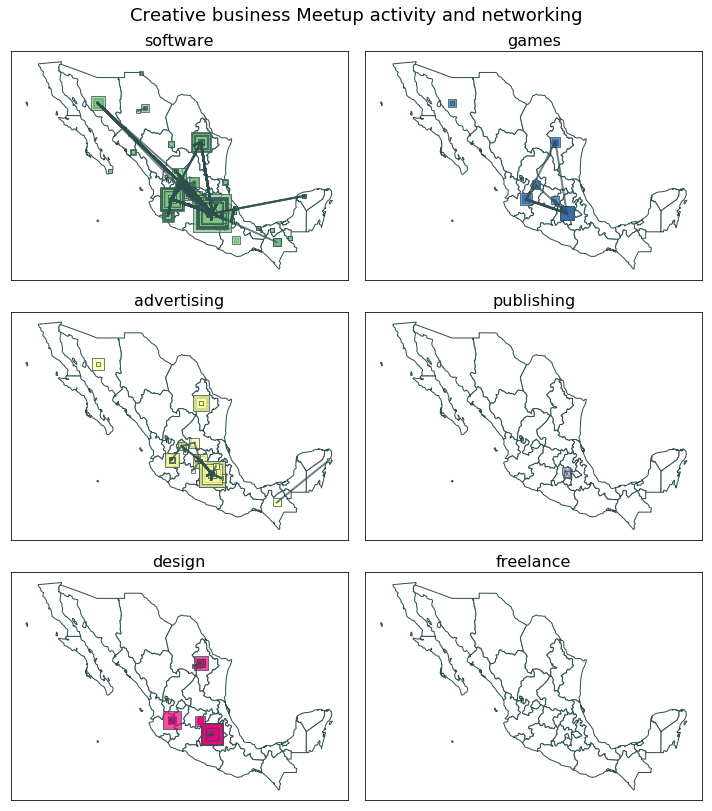

In [296]:
#And then we map
#NB We haven't added legends yet - 
#the graphs are not strictly comparable because the color-scale is set based on the distribution for each variable

fig,ax = plt.subplots(figsize=(10,11),nrows=3,ncols=2)

for num,sector in enumerate(sector_nets):
    print(sector[0])
    
    if num<3:
        col=0
        row=num
    else:
        col=1
        row=num-3
    
    #estados.plot(ax=ax[row][col])
    plot_meetup_map(sector_nets[num][1],ax=ax[row][col],sector_name=sector_nets[num][0])
    
fig.suptitle('Creative business Meetup activity and networking',y=1.02,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date}_meetup_maps.png'.format(date=today_str),bbox_inches='tight')

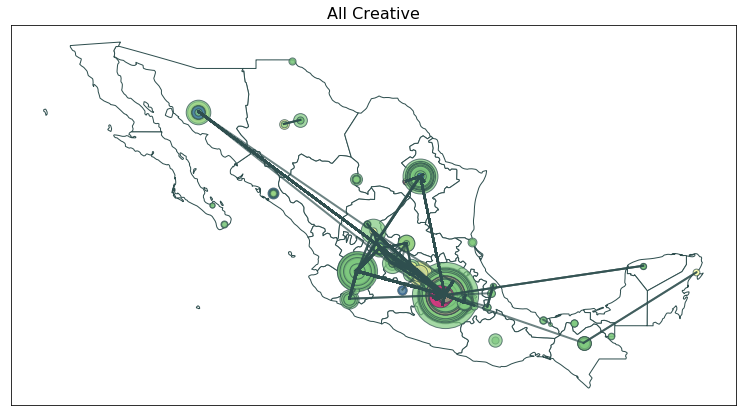

In [281]:
#Extract networks for all sectors
all_network = meetupNetworks(mu_df).get_all_network().subset_network(
    [x for x in sectors_sorted if x!='not_creative']).filter_weights(0.75).network


fig,ax = plt.subplots(figsize=(13,7))

plot_meetup_map(all_network,ax=ax,sector_name='All Creative')

plt.savefig(fig_path+'/{date}_all_meetup_maps.png'.format(date=today_str),bbox_inches='tight')

